# All imports

In [17]:
# for files
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import gc
import multiprocessing
# nltk
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import utils
# gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import gensim.models.keyedvectors as word2vec
# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import Sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
sns.set_style('dark')

# Load data

In [3]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1e_-vl9IncR4T9P6KiCxVnmeOZJgxIAXr', dest_path='./data/train_csv.zip')
gdd.download_file_from_google_drive(file_id='12aofsxmKuzE5wLeFmTA0qX6x5jKLDzGY', dest_path='./data/glove.zip')
gdd.download_file_from_google_drive(file_id='18LzLy-AZDGafGy65YROc5r0XJaG23HBp', dest_path='./data/fasttext.zip')
gdd.download_file_from_google_drive(file_id='1AUQ-vzZM3B-ieKl9qCagSWlo-888gmbK', dest_path='./data/word2vec.gz')

In [ ]:
! unzip ./data/fasttext.zip

Archive:  ./data/fasttext.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
#! gunzip ./data/word2vec.gz

In [4]:
! unzip ./data/train_csv.zip 

Archive:  ./data/train_csv.zip
  inflating: train.csv               


In [ ]:
! unzip ./data/glove.zip -d ./glove

Archive:  ./data/glove.zip
  inflating: ./glove/glove.twitter.27B.25d.txt  
  inflating: ./glove/glove.twitter.27B.50d.txt  
  inflating: ./glove/glove.twitter.27B.100d.txt  
  inflating: ./glove/glove.twitter.27B.200d.txt  


In [5]:
df = pd.read_csv('/content/train.csv')

# EDA

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
label_columns = df.select_dtypes(include=[int]).columns

Labels are binary

In [ ]:
df.loc[:,label_columns].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Add clean label

In [7]:
df['clean'] = df.loc[:,label_columns].apply(lambda x: 1 if x.sum() == 0 else 0, axis=1)
# add clean column to label columns
label_columns = df.select_dtypes(include=[int]).columns

In [ ]:
count_per_label = [df[column].sum() for column in label_columns]

Task seems to be inbalanced

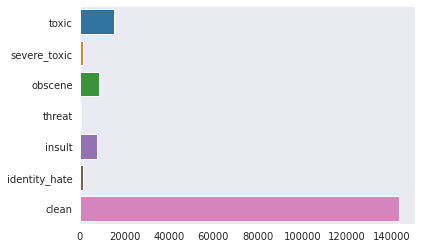

In [ ]:
sns.barplot(x=count_per_label, y=label_columns)

Compare total number of bad comments to clean comments

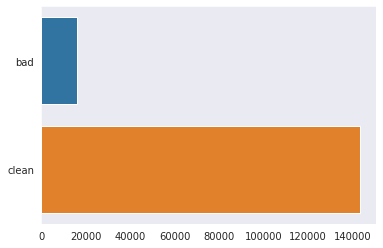

In [ ]:
sns.barplot(x=[df.shape[0] - df['clean'].sum(), df['clean'].sum()], y=['bad','clean'])

In [ ]:
concat_df = pd.concat([df['comment_text'].apply(lambda x: len(x)), df['clean']], axis=1)

In [ ]:
concat_df.rename(columns={'comment_text':'comment_text_length'}, inplace=True)

We can observe a difference in comment length distribution for clean and bad comments. Bad comments are shorter than clean.

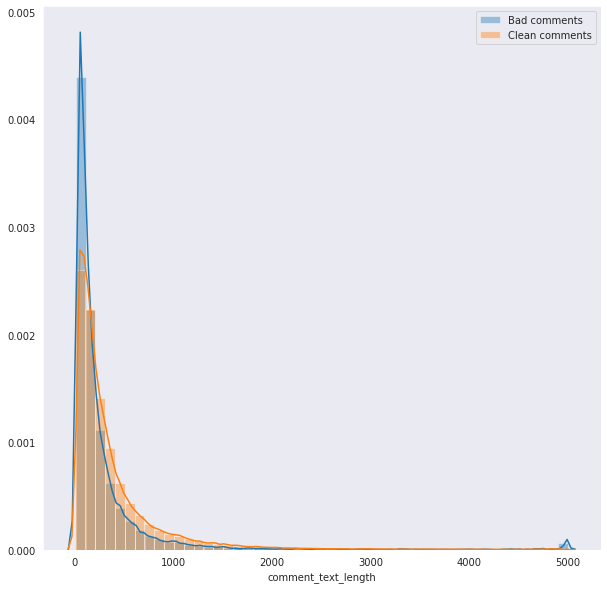

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(concat_df.query('clean == 0')['comment_text_length'], ax=ax, label='Bad comments')
sns.distplot(concat_df.query('clean == 1')['comment_text_length'], ax=ax, label='Clean comments')
ax.legend()

Let's evaluate the median, because we can use it for the reasonable choice of the sequence length.

In [ ]:
concat_df['comment_text_length'].median()

205.0

In [ ]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token),
                  words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         tokens))
    return filtered_tokens

In [ ]:
def visualize_most_popular(vectorised_data, vectorizer, words_num=20):
  feature_table = {val:key for (key, val) in vectorizer.vocabulary_.items()}
  sumed_data = vectorised_data.sum(axis=0)
  score_table = {feature:score for feature, score in enumerate(list(np.array(sumed_data).flatten()))}
  top_features = sorted(score_table.items(), reverse=True, key= lambda x: x[1])[:words_num]
  top_words = [feature_table[f[0]] for f in top_features]
  top_score = [f[1] for f in top_features]
  freq = {word:val for word, val in zip(top_words, top_score)}
  # Create and generate a word cloud image:
  wordcloud = WordCloud().fit_words(freq)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
def visualize_group(group_name):
  vectorizer = CountVectorizer(tokenizer=tokenize)
  vectorised_data = vectorizer.fit_transform(df[df[group_name] == 1]['comment_text'].values)
  visualize_most_popular(vectorised_data, vectorizer) 

Let's visualize the most popular words in different toxicity groups


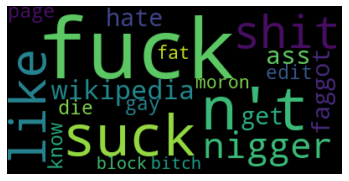

In [ ]:
visualize_group('toxic')

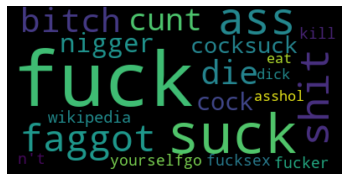

In [ ]:
visualize_group('severe_toxic')

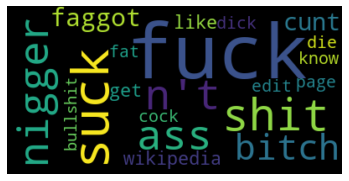

In [ ]:
visualize_group('obscene')

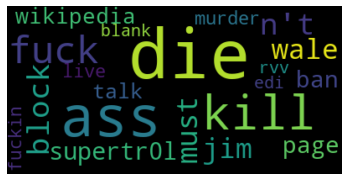

In [ ]:
visualize_group('threat')

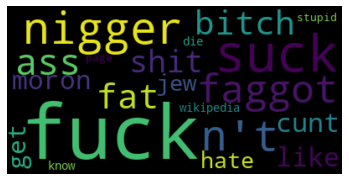

In [ ]:
visualize_group('insult')

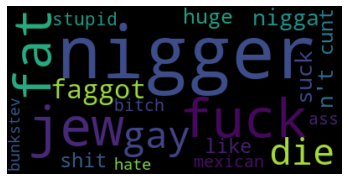

In [ ]:
visualize_group('identity_hate')

Clean group

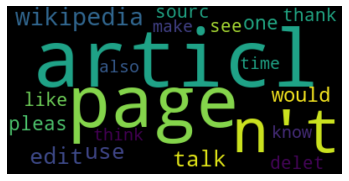

In [ ]:
vectorizer = CountVectorizer(tokenizer=tokenize)
vectorised_data = vectorizer.fit_transform(df[df['clean'] == 1]['comment_text'].values[:20000])
visualize_most_popular(vectorised_data, vectorizer)

We have to reduce data size due to significant computational time 

In [ ]:
df.shape

(159571, 9)

Use the rarest groups for stratification

In [8]:
_, reduced_df = train_test_split(df,stratify=df.loc[:,['severe_toxic','identity_hate','threat']],test_size=0.1)
reduced_df.shape

(15958, 9)

It seems that balance has been saved

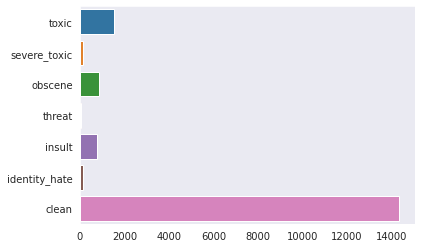

In [ ]:
count_per_label = [reduced_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

Train/test split

In [9]:
train_df, test_df = train_test_split(reduced_df,test_size=0.3,stratify=reduced_df.loc[:,['severe_toxic','identity_hate','threat']])

In [ ]:
print(train_df.shape, test_df.shape)

(11170, 9) (4788, 9)


Balance has been saved

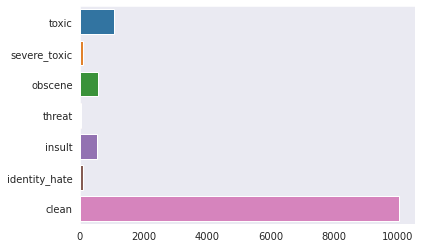

In [ ]:
count_per_label = [train_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

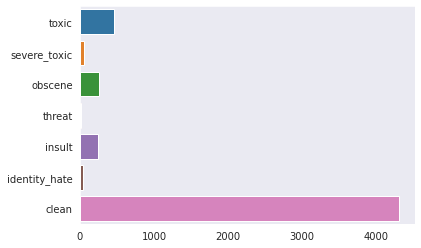

In [ ]:
count_per_label = [test_df[column].sum() for column in label_columns]
sns.barplot(x=count_per_label, y=label_columns)

# Classical approaches

In [ ]:
def tokenize(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    tokens = (list(map(lambda token: PorterStemmer().stem(token),
                  words)));
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         tokens))
    return filtered_tokens

In [ ]:
def fit_predict_classical(train_df, test_df, vectorizer, text_column, list_classes):
  X_vec_train = vectorizer.fit_transform(train_df[text_column].values)
  clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', C=0.8)).fit(X_vec_train, train_df.loc[:,list_classes])
  prediction_train = clf.predict(X_vec_train)
  X_vec_test = vectorizer.transform(test_df[text_column].values)
  prediction_test = clf.predict(X_vec_test)
  return prediction_train, prediction_test

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", 'clean']

## Count vectors

In [ ]:
prediction_train, prediction_test = fit_predict_classical(train_df, test_df, CountVectorizer(tokenizer=tokenize),'comment_text', list_classes)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print(classification_report(train_df.loc[:,list_classes], prediction_train,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.91      1.00      0.95      1046
 severe_toxic       0.60      1.00      0.75       111
      obscene       0.92      1.00      0.95       585
       threat       0.83      1.00      0.91        34
       insult       0.80      1.00      0.89       551
identity_hate       0.82      1.00      0.90        98
        clean       1.00      0.99      1.00     10050

    micro avg       0.97      0.99      0.98     12475
    macro avg       0.84      1.00      0.91     12475
 weighted avg       0.97      0.99      0.98     12475
  samples avg       0.98      0.99      0.99     12475



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_df.loc[:,list_classes], prediction_test,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.67      0.74      0.70       433
 severe_toxic       0.35      0.71      0.47        48
      obscene       0.73      0.76      0.74       235
       threat       0.14      0.21      0.17        14
       insult       0.51      0.65      0.57       214
identity_hate       0.21      0.28      0.24        43
        clean       0.97      0.97      0.97      4329

    micro avg       0.89      0.92      0.90      5316
    macro avg       0.51      0.62      0.55      5316
 weighted avg       0.90      0.92      0.91      5316
  samples avg       0.92      0.93      0.92      5316



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TFIDF

In [ ]:
prediction_train, prediction_test = fit_predict_classical(train_df, test_df, TfidfVectorizer(tokenizer=tokenize),'comment_text',list_classes)

In [ ]:
print(classification_report(train_df.loc[:,list_classes], prediction_train,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.80      0.99      0.88      1046
 severe_toxic       0.41      1.00      0.58       111
      obscene       0.82      1.00      0.90       585
       threat       0.46      1.00      0.63        34
       insult       0.72      1.00      0.84       551
identity_hate       0.43      1.00      0.60        98
        clean       1.00      0.97      0.99     10050

    micro avg       0.93      0.98      0.95     12475
    macro avg       0.66      0.99      0.77     12475
 weighted avg       0.95      0.98      0.96     12475
  samples avg       0.96      0.97      0.96     12475



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_df.loc[:,list_classes], prediction_test,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.67      0.78      0.72       433
 severe_toxic       0.34      0.81      0.48        48
      obscene       0.70      0.79      0.74       235
       threat       0.23      0.50      0.32        14
       insult       0.56      0.75      0.64       214
identity_hate       0.23      0.56      0.33        43
        clean       0.98      0.96      0.97      4329

    micro avg       0.88      0.92      0.90      5316
    macro avg       0.53      0.74      0.60      5316
 weighted avg       0.91      0.92      0.91      5316
  samples avg       0.92      0.94      0.92      5316



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Embeddings

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", 'clean']
y = train_df[list_classes].values
list_sentences_train = train_df["comment_text"]
list_sentences_test = test_df["comment_text"]

In [ ]:
def tokenize_without_normalization(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words
                  if word not in cachedStopWords]
    
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token)>=min_length,
         words))
    return " ".join(filtered_tokens)

In [ ]:
list_sentences_train=list(map(tokenize_without_normalization, list_sentences_train.values))
list_sentences_test=list(map(tokenize_without_normalization, list_sentences_test.values))

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,oov_token='unk')
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='/content/glove/glove.twitter.27B.25d.txt'
            embed_size = 25
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("/content/data/word2vec", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='/content/wiki-news-300d-1M.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                # we have some crashed embeddings
                if len(values) != embed_size+1:
                  continue
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs 
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [ ]:
def create_network():
  inp = Input(shape=(maxlen, )) 
  x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
  x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(7, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  return model

## Fasttext

In [ ]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

Loaded 999994 word vectors.
total embedded: 27871 common words


In [ ]:
nn = create_network()

In [ ]:
nn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 300)          10802100  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 120)          173280    
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [ ]:
%%time
batch_size = 128
epochs = 20
hist = nn.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
79/79 [==============================] - 101s 1s/step - loss: 0.2297 - accuracy: 0.8702 - val_loss: 0.1538 - val_accuracy: 0.9096
Epoch 2/20
79/79 [==============================] - 101s 1s/step - loss: 0.1691 - accuracy: 0.8997 - val_loss: 0.1482 - val_accuracy: 0.9096
Epoch 3/20
79/79 [==============================] - 100s 1s/step - loss: 0.1638 - accuracy: 0.8997 - val_loss: 0.1424 - val_accuracy: 0.9096
Epoch 4/20
79/79 [==============================] - 100s 1s/step - loss: 0.1563 - accuracy: 0.8997 - val_loss: 0.1326 - val_accuracy: 0.9096
Epoch 5/20
79/79 [==============================] - 101s 1s/step - loss: 0.1438 - accuracy: 0.8988 - val_loss: 0.1230 - val_accuracy: 0.9114
Epoch 6/20
79/79 [==============================] - 99s 1s/step - loss: 0.1353 - accuracy: 0.9026 - val_loss: 0.1151 - val_accuracy: 0.9248
Epoch 7/20
79/79 [==============================] - 100s 1s/step - loss: 0.1221 - accuracy: 0.9167 - val_loss: 0.1086 - val_accuracy: 0.9293
Epoch 8/20
79/

In [ ]:
prediction_test = nn.predict(X_test)

In [ ]:
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0

In [ ]:
print(classification_report(test_df.loc[:,list_classes], prediction_test,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.85      0.49      0.62       429
 severe_toxic       0.50      0.04      0.08        48
      obscene       0.87      0.58      0.70       254
       threat       0.00      0.00      0.00        14
       insult       0.78      0.56      0.65       219
identity_hate       0.00      0.00      0.00        43
        clean       0.95      0.99      0.97      4338

    micro avg       0.94      0.89      0.91      5345
    macro avg       0.56      0.38      0.43      5345
 weighted avg       0.92      0.89      0.90      5345
  samples avg       0.94      0.93      0.93      5345



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Glove

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

Loaded 1193513 word vectors.
total embedded: 26495 common words


In [ ]:
nn = create_network()

In [ ]:
nn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 25)           899500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0   

In [ ]:
%%time
batch_size = 128
epochs = 10
hist = nn.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 10053 samples, validate on 1117 samples
Epoch 1/10
10053/10053 [==============================] - 39s 4ms/step - loss: 0.2193 - accuracy: 0.9375 - val_loss: 0.1564 - val_accuracy: 0.9550
Epoch 2/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1673 - accuracy: 0.9542 - val_loss: 0.1526 - val_accuracy: 0.9550
Epoch 3/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1639 - accuracy: 0.9543 - val_loss: 0.1505 - val_accuracy: 0.9550
Epoch 4/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1610 - accuracy: 0.9542 - val_loss: 0.1488 - val_accuracy: 0.9550
Epoch 5/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1589 - accuracy: 0.9543 - val_loss: 0.1484 - val_accuracy: 0.9550
Epoch 6/10
10053/10053 [==============================] - 38s 4ms/step - loss: 0.1579 - accuracy: 0.9543 - val_loss: 0.1473 - val_accuracy: 0.9550
Epoch 7/10
10053/10053 [==============================] - 39s 4ms/ste

In [ ]:
prediction_test = nn.predict(X_test)

In [ ]:
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0

In [ ]:
print(classification_report(test_df.loc[:,list_classes], prediction_test,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00       463
 severe_toxic       0.00      0.00      0.00        48
      obscene       0.00      0.00      0.00       260
       threat       0.00      0.00      0.00        14
       insult       0.00      0.00      0.00       250
identity_hate       0.00      0.00      0.00        43
        clean       0.90      1.00      0.95      4303

    micro avg       0.90      0.80      0.85      5381
    macro avg       0.13      0.14      0.14      5381
 weighted avg       0.72      0.80      0.76      5381
  samples avg       0.90      0.90      0.90      5381



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Doc2Vec

In [ ]:
train_tagged = train_df.apply(
    lambda x: TaggedDocument(words=tokenize(x['comment_text']),tags=[x.name]), axis=1)
test_tagged = test_df.apply(
    lambda x: TaggedDocument(words=tokenize(x['comment_text']),tags=[x.name]), axis=1)

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 11170/11170 [00:00<00:00, 1389394.30it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 11170/11170 [00:00<00:00, 2406285.35it/s]


CPU times: user 52.4 s, sys: 2.72 s, total: 55.1 s
Wall time: 31.9 s


In [ ]:
def vec_for_learning(model, tagged_docs,df):
    sents = tagged_docs.values
    targets, regressors = zip(*[(df.loc[doc.tags[0],label_columns].values, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged, train_df)
y_test, X_test = vec_for_learning(model_dbow, test_tagged, test_df)
y_train=np.asarray(y_train,dtype=int)
y_test=np.asarray(y_test,dtype=int)

In [ ]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)
prediction_train = clf.predict(X_train)
prediction_test = clf.predict(X_test)

In [ ]:
print(classification_report(y_train, prediction_train,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       0.83      0.00      0.01      1076
 severe_toxic       0.50      0.01      0.02       111
      obscene       1.00      0.01      0.01       574
       threat       0.00      0.00      0.00        34
       insult       0.50      0.00      0.00       537
identity_hate       0.00      0.00      0.00        98
        clean       0.90      1.00      0.95     10029

    micro avg       0.90      0.81      0.85     12459
    macro avg       0.53      0.15      0.14     12459
 weighted avg       0.87      0.81      0.76     12459
  samples avg       0.90      0.90      0.90     12459



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test, prediction_test,\
                            target_names=list_classes))

               precision    recall  f1-score   support

        toxic       1.00      0.00      0.00       463
 severe_toxic       0.00      0.00      0.00        48
      obscene       1.00      0.00      0.01       260
       threat       0.00      0.00      0.00        14
       insult       0.00      0.00      0.00       250
identity_hate       0.00      0.00      0.00        43
        clean       0.90      1.00      0.95      4303

    micro avg       0.90      0.80      0.85      5381
    macro avg       0.41      0.14      0.14      5381
 weighted avg       0.85      0.80      0.76      5381
  samples avg       0.90      0.90      0.90      5381



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

In [12]:
! pip install simplerepresentations

In [13]:
# for BERT
from simplerepresentations import RepresentationModel

In [24]:
train_df, val_df = train_test_split(train_df,stratify=train_df.loc[:,['severe_toxic','identity_hate','threat']],test_size=0.1)

In [26]:
train_df.shape, val_df.shape, test_df.shape

((10053, 9), (1117, 9), (4788, 9))

In [27]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", 'clean']
y_train = train_df[list_classes].values
y_val = val_df[list_classes].values
y_test = test_df[list_classes].values
list_sentences_train = train_df["comment_text"].to_list()
list_sentences_val = val_df["comment_text"].to_list()
list_sentences_test = test_df["comment_text"].to_list()

In [15]:
model_type = 'roberta'
model_name = 'roberta-base'

representation_model = RepresentationModel(
    model_type=model_type,
    model_name=model_name,
    batch_size=128,
    max_seq_length=200, # truncate sentences to be less than or equal to 128 tokens
    combination_method='sum', # sum the last `last_hidden_to_use` hidden states
    last_hidden_to_use=1, # use the last 1 hidden states to build tokens representations
    verbose=0
)

In [28]:
class DataGenerator(Sequence):
    def __init__(self, representation_model, sentences, labels, batch_size, token_level=True):
        self.representation_model = representation_model
        self.sentences = sentences
        self.labels = labels
        self.batch_size = batch_size
        self.token_level = token_level

    def __len__(self):
        return int(np.ceil(len(self.sentences) / float(self.batch_size)))

    def __getitem__(self, idx):
        sentences_batch = np.array(self.sentences[idx * self.batch_size:(idx + 1) * self.batch_size])
        labels_batch = np.array(self.labels[idx * self.batch_size:(idx + 1) * self.batch_size])

        sentences_sen_batch, sentences_tok_batch = self.representation_model(sentences_batch)

        if self.token_level:
            sentences_batch = sentences_tok_batch
        else:
            sentences_batch = sentences_sen_batch

        return sentences_batch, np.array(labels_batch)

train_tok_generator = DataGenerator(representation_model, list_sentences_train, y_train, 128)
val_tok_generator = DataGenerator(representation_model, list_sentences_val, y_val, 128)
test_tok_generator = DataGenerator(representation_model, list_sentences_test, y_test, 128)

In [21]:
all_sentences_representations, all_tokens_representations = representation_model(list_sentences_train[0])

print(all_sentences_representations.shape)
print(all_tokens_representations.shape)
print(all_sentences_representations[0].shape)
print(all_tokens_representations[0].shape)

(34, 768)
(34, 200, 768)
(768,)
(200, 768)


In [29]:
inp = Input(shape=(200, 768, )) 
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(inp)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [30]:
%%time
model.fit_generator(train_tok_generator, epochs=10, validation_data=val_tok_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
79/79 [==============================] - 380s 5s/step - loss: 0.1897 - accuracy: 0.8819 - val_loss: 0.0920 - val_accuracy: 0.9391
Epoch 2/10
79/79 [==============================] - 394s 5s/step - loss: 0.0832 - accuracy: 0.9408 - val_loss: 0.0644 - val_accuracy: 0.9526
Epoch 3/10
79/79 [==============================] - 394s 5s/step - loss: 0.0667 - accuracy: 0.9488 - val_loss: 0.0612 - val_accuracy: 0.9588
Epoch 4/10
79/79 [==============================] - 397s 5s/step - loss: 0.0572 - accuracy: 0.9569 - val_loss: 0.0590 - val_accuracy: 0.9579
Epoch 5/10
79/79 [==============================] - 403s 5s/step - loss: 0.0538 - accuracy: 0.9591 - val_loss: 0.0588 - val_accuracy: 0.9615
Epoch 6/10
79/79 [==============================] - 407s 5s/step - loss: 0.0499 - accuracy: 0.9626 - val_loss: 0.0581 - val_accuracy: 0.9597
Epoch 7/10
79/79 [==============================] - 401s 5s/step - loss: 0.044

In [31]:
prediction_test = model.predict_generator(test_tok_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [32]:
prediction_test.shape

(4788, 7)

In [33]:
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0

In [34]:
print(classification_report(test_df.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']], prediction_test,\
                            target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']))

               precision    recall  f1-score   support

        toxic       0.84      0.76      0.80       495
 severe_toxic       0.75      0.06      0.12        48
      obscene       0.81      0.76      0.78       264
       threat       0.00      0.00      0.00        14
       insult       0.73      0.68      0.70       253
identity_hate       1.00      0.02      0.05        43
        clean       0.97      0.99      0.98      4272

    micro avg       0.94      0.92      0.93      5389
    macro avg       0.73      0.47      0.49      5389
 weighted avg       0.94      0.92      0.92      5389
  samples avg       0.95      0.95      0.94      5389



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
